# AI Fairness in Medicine: Integrated and Interactive Workshop

Let's take off our hats as medical staff and wear a new hat, AI developer, for a few hours. In the
end of this session, you will understand the basics of developing an AI solution for medical usage
through a simple example. You will also understand what is biases in AI development, their effects,
and a general idea on how to develop a fair AI solution.

There is no need to freak out even though you have zero experience in programming or even AI! This
material (which data scientists usually call it *notebook*) provides you a quick tutorial on the
machine learning lifecycle and does all the programming parts for you already.

## Part I: What does it mean to train an AI model?

There is no perfect answer in solving a problem using AI. There are many frameworks and methodology
that differ by the details, but the starting point is to understand what is the problem, what are
the data we have, and what is the goal to achieve using AI.

For example, in the context of medicine, an example problem could be to diagnose the patients given
a set of symptoms, to screen diseases or disorders given patient's imaging data, or to discover
new vaccine when the next pandemic arrives.

The diagram below depicts one viewpoint of the machine learning lifecycle. It explains briefly the
process of building an AI model to solve the predefined problem and to achieve the predefined goal.

<img src="https://towardsdatascience.com/wp-content/uploads/2024/11/1_dlG-Cju5ke-DKp8DQ9hiA@2x.jpeg"
alt="ml-lifecycle" width="400"/>

*Source: https://towardsdatascience.com/wp-content/uploads/2024/11/1_dlG-Cju5ke-DKp8DQ9hiA@2x.jpeg*

1. **Data Collection**

   We start by gathering relevant medical information like patient records, lab results, and imaging
   scans. AI developers must understand the problem well, especially in the medical context, and
   should find relevant data, or the resources, to build the AI solution efficiently.

2. **Data Cleaning**

   The raw data often contains errors, missing values, or inconsistencies that need fixing. We
   carefully review and correct these issues to ensure the information is accurate and reliable for
   analysis.

3. **Feature Engineering**

   This is when *inductive bias* first comes in. Here we identify and organize the most important
   pieces of medical data that do not exist originally in the data, but we complement them to help
   AI become more accurate. For example, we might calculate BMI from height and weight measurements,
   or track changes in lab values over time instead of given AI the raw values.

4. **Model Training**

    The AI model learns to capture patterns from between the collected data and the task"s goal
    after AI developers provide a set of constraints or rules. For example, capturing the hidden
    relationship between a protein and the docking site or recognizing the pattern between apneic
    episode and the SpO2 signal. This AI model can also be large language models (LLM) that we hear
    everyday in some specific tasks!

5. **Evaluation**

    After the model has learned from the data, we rigorously test its performance using metrics
    doctors understand, like sensitivity and specificity. We also check for biases to ensure that
    the patterns the model learned are fair and accurate across different patient groups before
    clinical use.

6. **Deployment**

    Once validated, we integrate the model into hospital systems where it can assist with tasks like
    flagging abnormal test results. This is done carefully with proper staff training and monitoring
    protocols.

7. **Monitoring**

    After launch, we continuously track the model"s performance in real-world use. Just like medical
    guidelines evolve, we update the models as we get new data or discover ways to improve them.

This ongoing cycle helps create AI tools that truly support clinical work while maintaining safety
and reliability. Your expertise remains essential for interpreting results and making final
decisions!

## Part II: Let's build your first medical AI model!

In this workshop, we will use a real-world medical dataset from the
[WiDS Datathon 2020](https://www.kaggle.com/competitions/widsdatathon2020/data), which contains
anonymized patient records from intensive care units (ICUs) around the world. The dataset includes a
wide range of clinical features such as demographics, vital signs, laboratory results, and
comorbidities collected during the first 24 hours of a patient's ICU stay.

While the original competition focused on predicting in-hospital mortality (`hospital_death`), our
goal will be to develop a model that predicts whether a patient has cirrhosis, using the `cirrhosis`
column as our target variable. This shift allows us to explore the challenges and considerations
involved in building AI models for different clinical outcomes, while practicing essential steps in
the machine learning workflow.

Let's first load the data and visualize it to understand it better.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

sns.set_theme(style="white", font_scale=1.2)

In [2]:
df = pd.read_csv("./data/training_v2.csv")

This is a sample of our data. We only see a few rows and a few columns.

In [3]:
df

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,0,75.0,23.060250,0,Caucasian,M,177.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,66119,13486,121,0,56.0,47.179671,0,Caucasian,F,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,8981,58179,195,0,48.0,27.236914,0,Caucasian,M,170.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,33776,120598,66,0,NaN,23.297481,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


Plot below shows the distribution of each demographic traits including age and gender.

<Axes: xlabel='gender', ylabel='Count'>

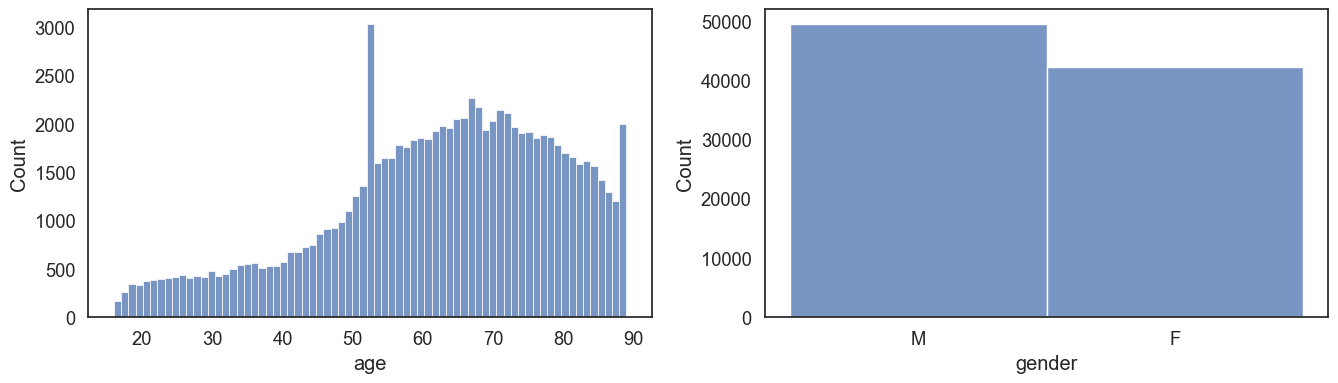

In [4]:
_, axes = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(data=df, x="age", ax=axes[0])
sns.histplot(data=df, x="gender", ax=axes[1])

This dataset also contains the prevalence of 6 diseases: leukemia, hepatic failure,
immunosuppression, lymphoma, cirrhosis, and aids. Let's take a quick look on how each disease
prevalence distributes across gender and ethnicity.

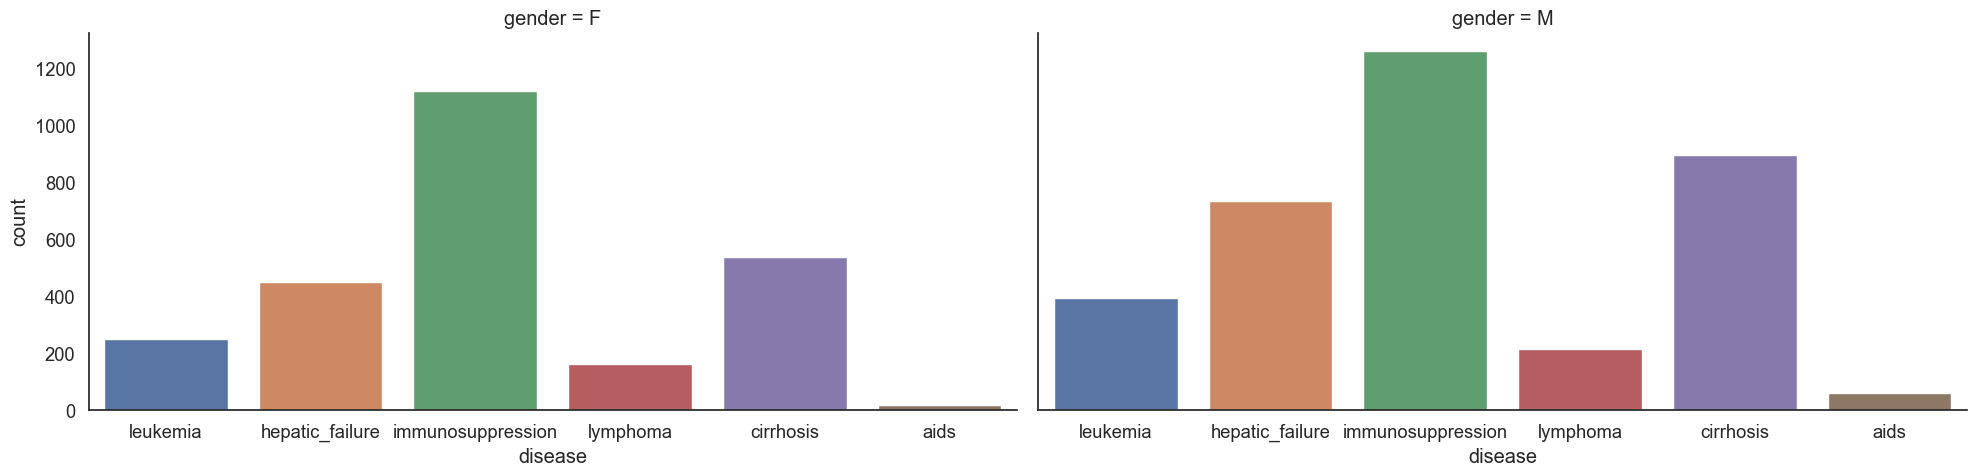

In [5]:
DISEASES = ["leukemia", "hepatic_failure", "immunosuppression", "lymphoma", "cirrhosis", "aids"]
long_df = pd.melt(
    df,
    id_vars=["patient_id", "gender", "ethnicity"],
    value_vars=DISEASES,
    value_name="presence",
    var_name="disease",
)

sns.catplot(
    data=long_df[long_df["presence"] == 1],
    x="disease",
    col="gender",
    hue="disease",
    kind="count",
    aspect=2,
    legend=False,
)

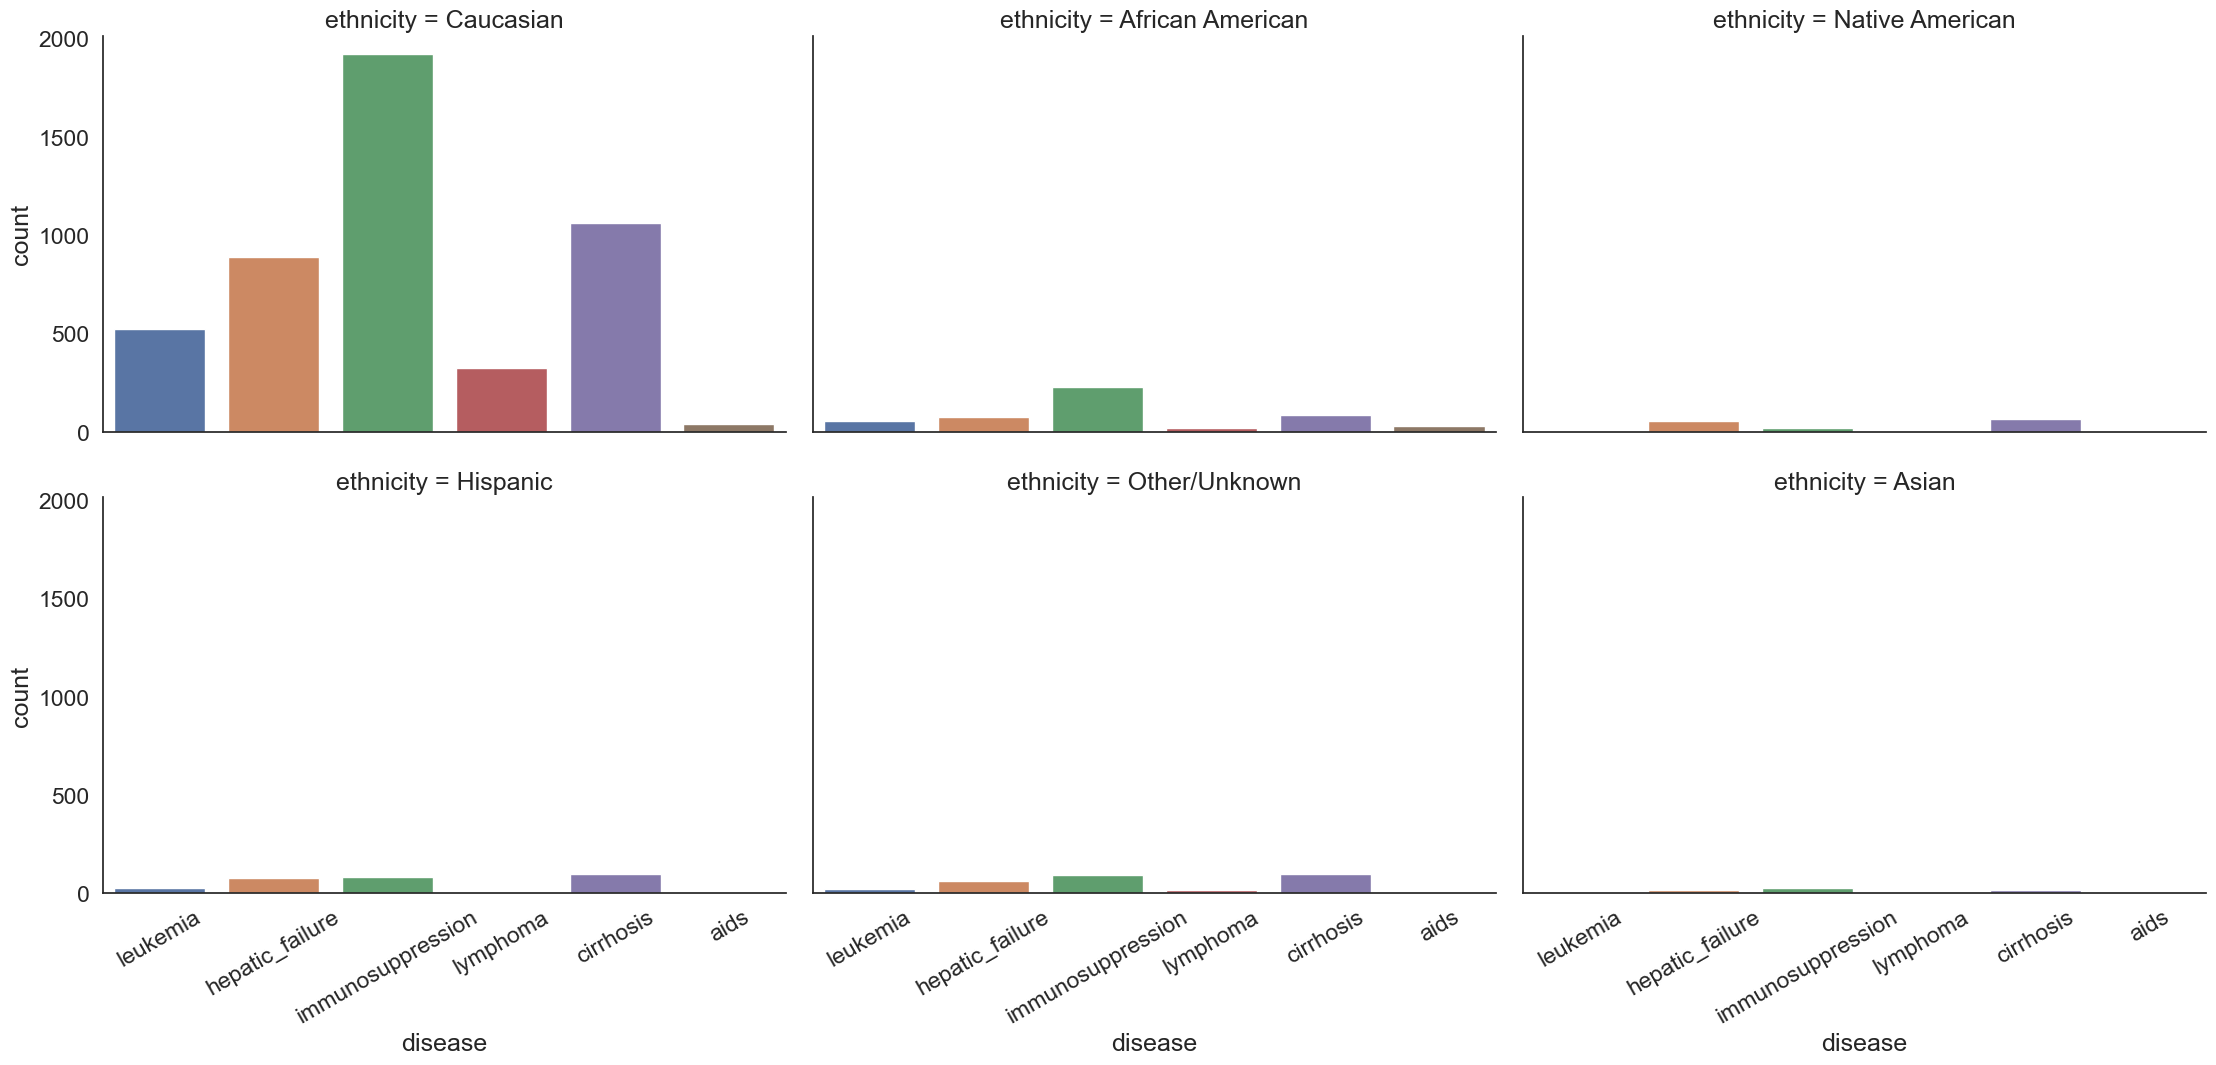

In [6]:
sns.set_theme(style="white", font_scale=1.5)
g = sns.catplot(
    data=long_df[long_df["presence"] == 1],
    x="disease",
    col="ethnicity",
    col_wrap=3,
    hue="disease",
    kind="count",
    legend=False,
    aspect=1.5,
)

for ax in g.axes.flatten():
    ax.tick_params(axis="x", rotation=30)

**🔍 Findings**

- **Mean age is 62**, left skewed. Younger people are underrepresented.
- **Similar number of males and females but men are likely to have disease**.
  
  The difference is significant in cirrhosis, hepatic failure, aids, and leukemia. An educated guess
  for the greater prevalence of cirrhosis and aids in men could be that they drink more and are prone
  to higher risk in sexual behaviors respectively.
- **77% of patients are white**.
  
  Although white patients are the majority, they show a unique distribution of the disease prevalence
  compared to other ethnicities.

There are also other data attributes that we can extract from the data. These attributes are what
we usually call them *features* in the context of machine learning. 

In [7]:
print("\n".join(df.columns.tolist()))

encounter_id
patient_id
hospital_id
hospital_death
age
bmi
elective_surgery
ethnicity
gender
height
hospital_admit_source
icu_admit_source
icu_id
icu_stay_type
icu_type
pre_icu_los_days
readmission_status
weight
albumin_apache
apache_2_diagnosis
apache_3j_diagnosis
apache_post_operative
arf_apache
bilirubin_apache
bun_apache
creatinine_apache
fio2_apache
gcs_eyes_apache
gcs_motor_apache
gcs_unable_apache
gcs_verbal_apache
glucose_apache
heart_rate_apache
hematocrit_apache
intubated_apache
map_apache
paco2_apache
paco2_for_ph_apache
pao2_apache
ph_apache
resprate_apache
sodium_apache
temp_apache
urineoutput_apache
ventilated_apache
wbc_apache
d1_diasbp_invasive_max
d1_diasbp_invasive_min
d1_diasbp_max
d1_diasbp_min
d1_diasbp_noninvasive_max
d1_diasbp_noninvasive_min
d1_heartrate_max
d1_heartrate_min
d1_mbp_invasive_max
d1_mbp_invasive_min
d1_mbp_max
d1_mbp_min
d1_mbp_noninvasive_max
d1_mbp_noninvasive_min
d1_resprate_max
d1_resprate_min
d1_spo2_max
d1_spo2_min
d1_sysbp_invasive_max
d1_s

Let's take a look at a few examples of the features we have. As our problem is to predict whether a
particular has cirrhosis, we handpicked a few features that are likely related to liver function
(such as albumin, bilirubin, INR, platelets, and age). In the following cells, we visualize the
distributions of these features for patients with and without cirrhosis.

This process is part of Exploratory Data Analysis (EDA), a crucial step for machine learning
practitioners. EDA helps us understand the data, identify patterns, spot anomalies, and select
relevant features, ultimately guiding better model development and reducing the risk of bias or
errors.

In [8]:
DISPLAY_FEATURES = [
    "d1_albumin_max",
    "d1_albumin_min",
    "d1_bilirubin_max",
    "d1_bilirubin_min",
    "d1_inr_max",
    "d1_inr_min",
    "d1_platelets_max",
    "d1_platelets_min",
    "age",    
]

In [9]:
long_df = pd.melt(
    df,
    id_vars=["patient_id", "cirrhosis"],
    value_vars=DISPLAY_FEATURES,
    value_name="value",
    var_name="feature",
)

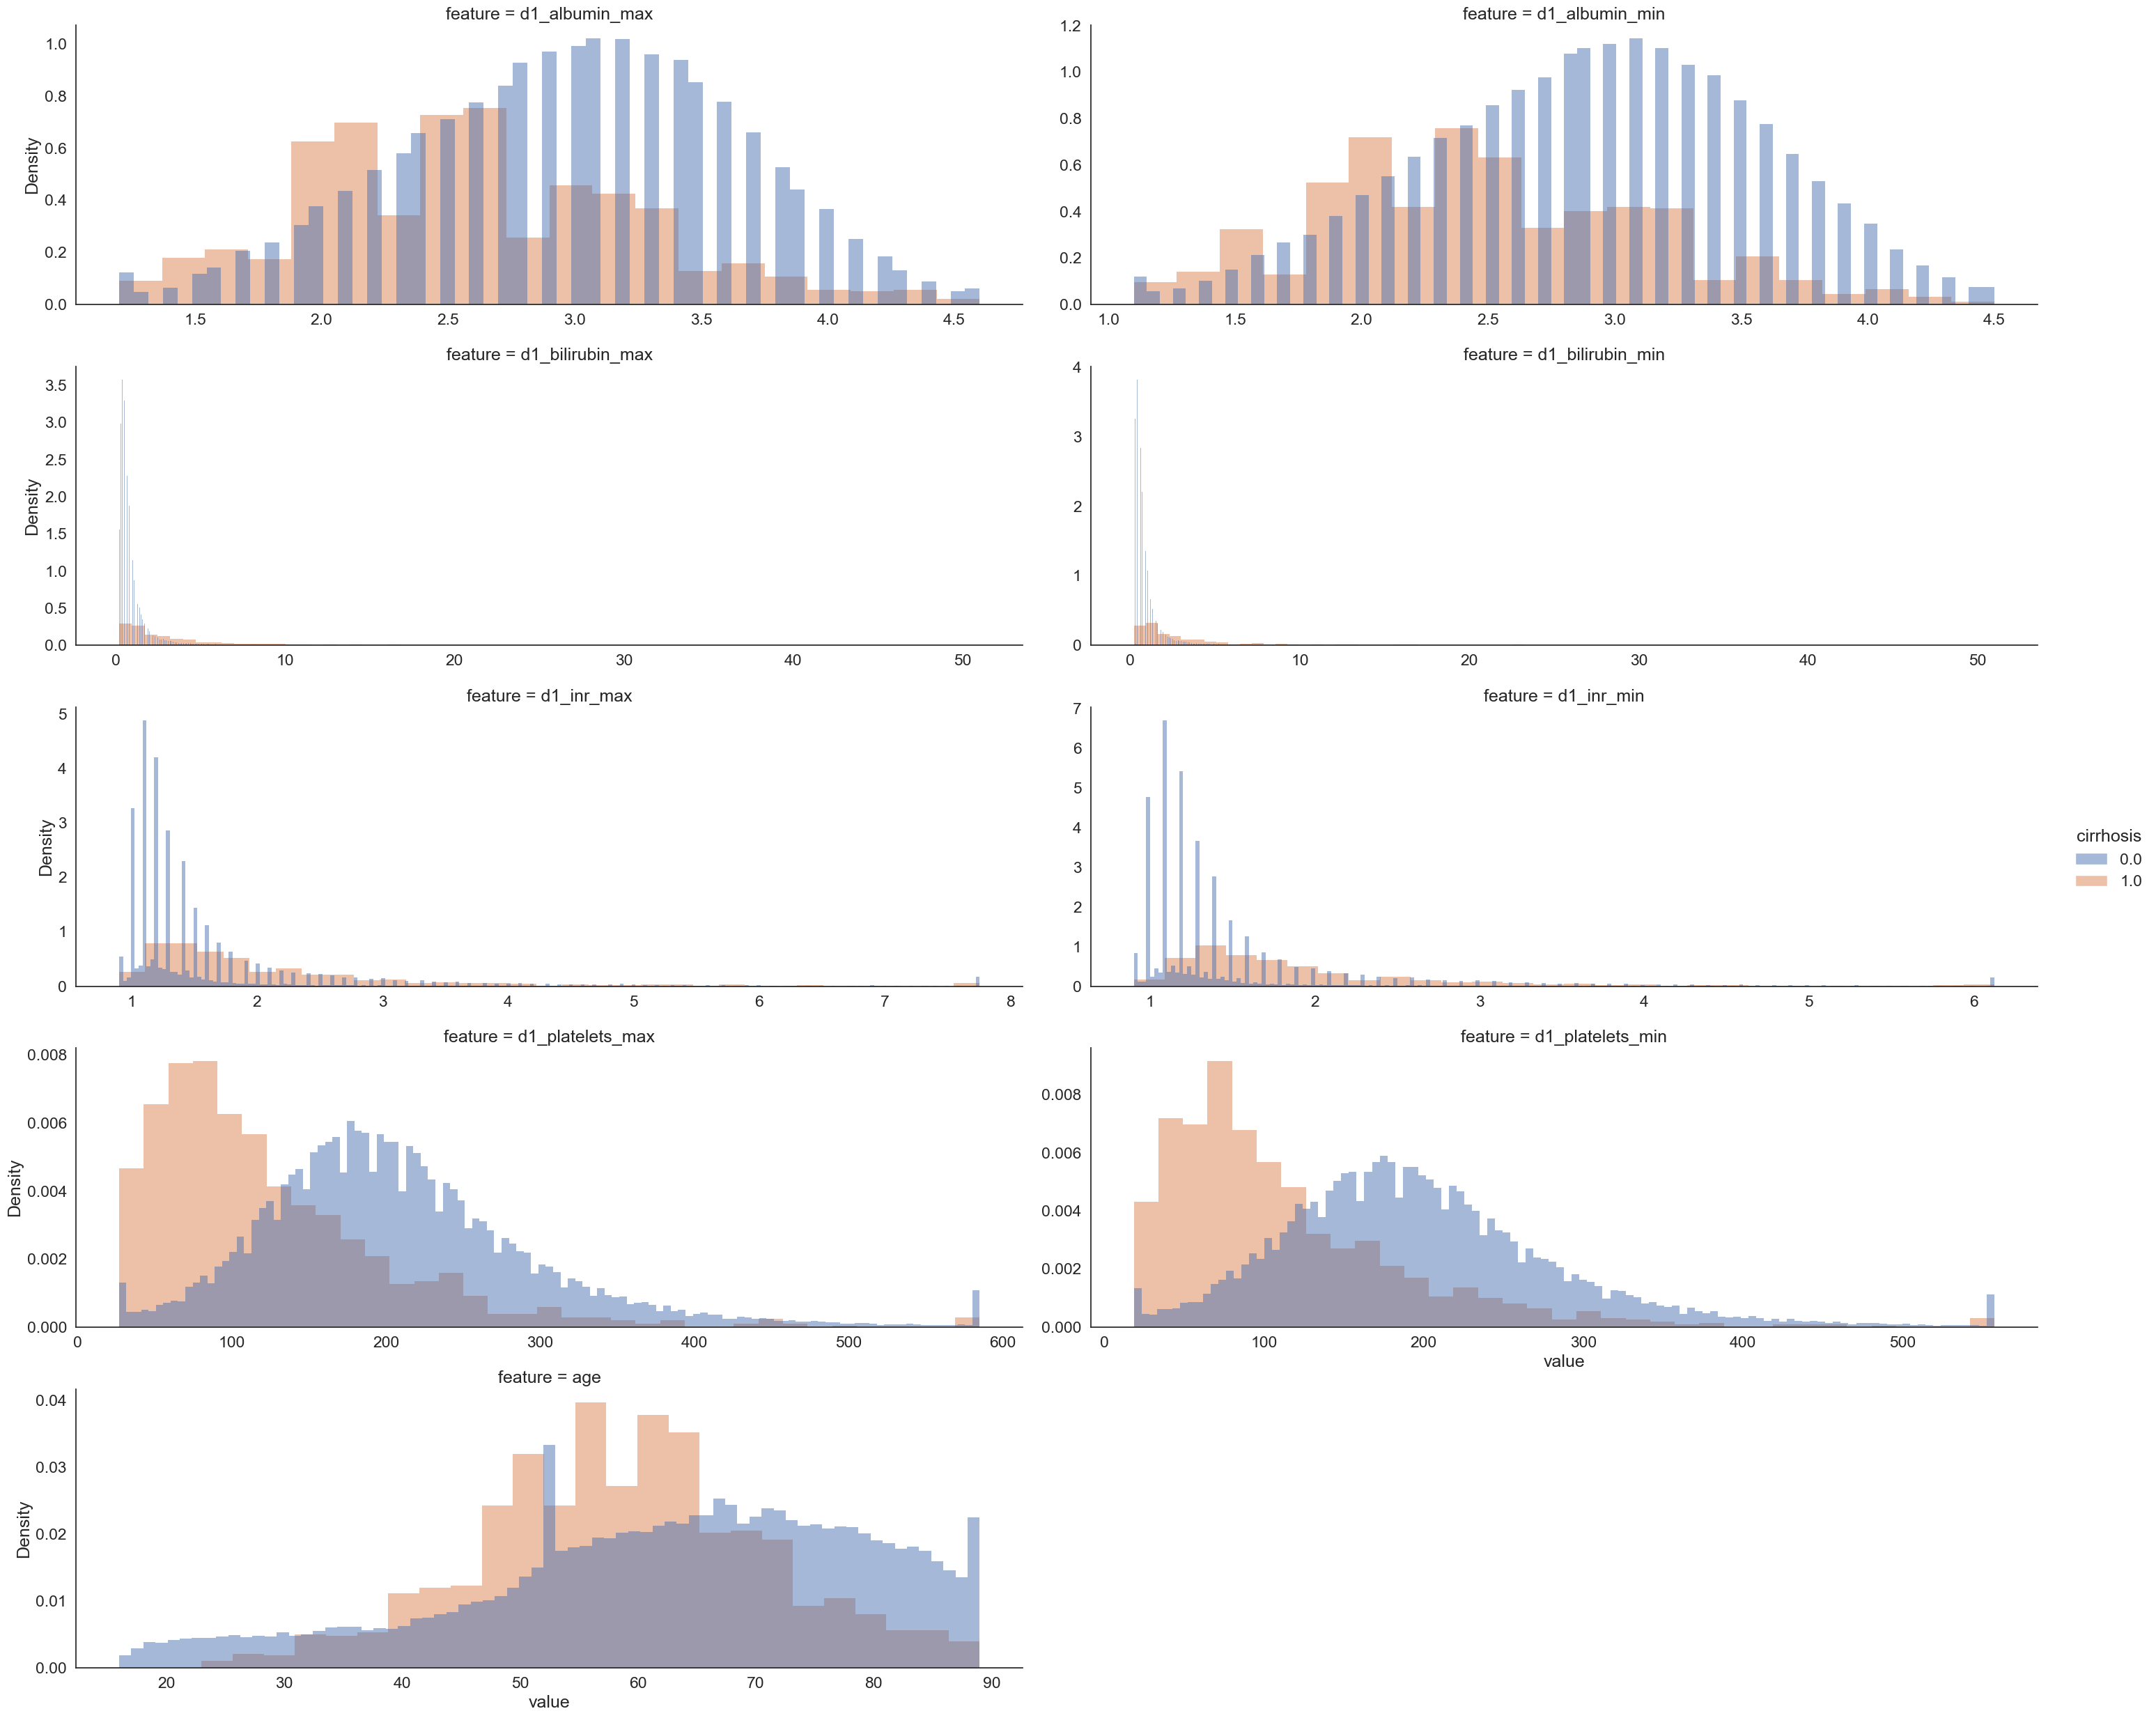

In [10]:
sns.displot(
    data=long_df,
    x="value",
    hue="cirrhosis",
    col="feature",
    stat="density",
    common_norm=False,
    common_bins=False,
    facet_kws={"sharex": False, "sharey": False},
    aspect=3,
    col_wrap=2,
)

In [11]:
# Play around with this
FEATURES = [
    "d1_albumin_max", "d1_albumin_min",
    "d1_inr_max","d1_inr_min",
    "d1_bilirubin_max", "d1_bilirubin_min",
    "d1_platelets_min",
    "map_apache", "d1_mbp_min",
    "creatinine_apache", "d1_creatinine_max",
    "urineoutput_apache", 
    "bun_apache",
    "d1_sodium_min", "d1_potassium_max",
    "d1_temp_max", "d1_temp_min",
    "d1_wbc_max", "d1_wbc_min",
    "d1_lactate_max"
]
GROUPS = ["patient_id", "gender", "age", "ethnicity"]
TARGET = "cirrhosis"

In [12]:
def train_and_evaluate(df, features: list[str], target: str, groups: list[str],
                       use_ethnicity: bool, everyone_as_african_american: bool = False):
    # Preprocess target column. We don't subjects with undefined value on any of the related columns.
    df = df.dropna(subset=features+[target]+groups)

    if use_ethnicity:
        features = features[:] + ["ethnicity"]

    X = df[features]
    y = df[target]
    group = df[groups]


    # Split the data into training and test sets
    X_train, X_test, y_train, y_test, _, group_test = train_test_split(
        X, y, group, test_size=0.3, random_state=42)

    if everyone_as_african_american and use_ethnicity:
        X_test["ethnicity"] = "African American"

    float_transformer = Pipeline([
        # Preprocess/clean the data with N/A values.
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    # Convert ethnicity if available, add it at the front of the pipeline
    if use_ethnicity:
        transformer = ColumnTransformer(
            transformers=[
                ("encoder", OrdinalEncoder(), ["ethnicity"]),
            ],
            remainder=float_transformer,
        )
    else:
        transformer = float_transformer

    model = Pipeline([
        ("transformer", transformer),
        # Add our classifier.
        ("classifier", RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            min_samples_split=10,
        ))
    ])

    # Fit the model to the training data and make predictions on the test data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    result_df = pd.DataFrame({
        "ground_truth": y_test,
        "prediction": y_pred,
    })
    result_df["TP"] = (result_df["ground_truth"] == 1) & (result_df["prediction"] == 1)
    result_df["TN"] = (result_df["ground_truth"] == 0) & (result_df["prediction"] == 0)
    result_df["FP"] = (result_df["ground_truth"] == 0) & (result_df["prediction"] == 1)
    result_df["FN"] = (result_df["ground_truth"] == 1) & (result_df["prediction"] == 0)

    result_df = pd.concat([result_df, group_test], axis=1)
    return result_df

Now let's practice what we have discussed. From the list below, choose **two** or **three** problems
that you are familiar with then proceed.

Given a problem and a goal, which types of patient data should we collect? And how would it help
constructing an accurate model? What are the other use cases in ICU care or medical practice that we
can apply this solution to? Do they have the same format of data? Can we apply the same data
cleaning method? If you cannot think of any, what about applying the same modeling technique to the
following problems?

1. Estimating ST-elevation from ECG signal
2. Detecting lung cancer from CXR images
3. Adjusting insulin dose from CGM data
4. Sepsis prediction in the ICU
5. Early warning system (EWS) for deterioration
6. Data extraction from clinician notes for flowsheets
7. Bed management

Discuss your thoughts with your group!

## Part III: Monitoring your AI model

A confusion matrix is a fundamental tool for evaluating the performance of a classification model.
It is a table that summarizes the number of correct and incorrect predictions made by the model,
broken down by each class. The matrix displays counts of true positives (TP), true negatives (TN),
false positives (FP), and false negatives (FN), allowing us to see not only the overall accuracy but
also the types of errors the model is making. This detailed breakdown helps identify whether the
model is biased toward certain classes or is systematically making specific types of mistakes.

<img src="https://www.researchgate.net/publication/377027146/figure/fig5/AS:11431281215285308@1704113587226/The-Matrix-of-TP-FP-FN-TN-Precision-Recall-dan-Accuracy.ppm"
alt="cm-definition" width="400"/>

Beyond the confusion matrix, other important evaluation metrics include precision, recall
(sensitivity), specificity, F1-score, and the area under the receiver operating characteristic curve
(AUC-ROC).

- **Precision** measures the proportion of positive predictions that are actually correct.
- **Recall** measures the proportion of actual positives that are correctly identified.
- The **F1-score** provides a balance between precision and recall, especially useful in imbalanced
  datasets.
- **AUC-ROC** evaluates the models ability to distinguish between classes across different thresholds.

These metrics provide a more comprehensive understanding of model performance, especially in medical
or high-stakes applications where certain types of errors may have greater consequences.


In [13]:
def plot_result_df(data: pd.DataFrame):
    _, axes = plt.subplots(1, 2, figsize=(16, 4))
    kwargs = {"annot": True, "robust": True, "fmt": "d"}
    _ = sns.heatmap(data=data.groupby("ethnicity")[["TP", "TN", "FP", "FN"]].sum(), ax=axes[0], **kwargs)
    _ = sns.heatmap(data=data.groupby("gender")[["TP", "TN", "FP", "FN"]].sum(), ax=axes[1], **kwargs)

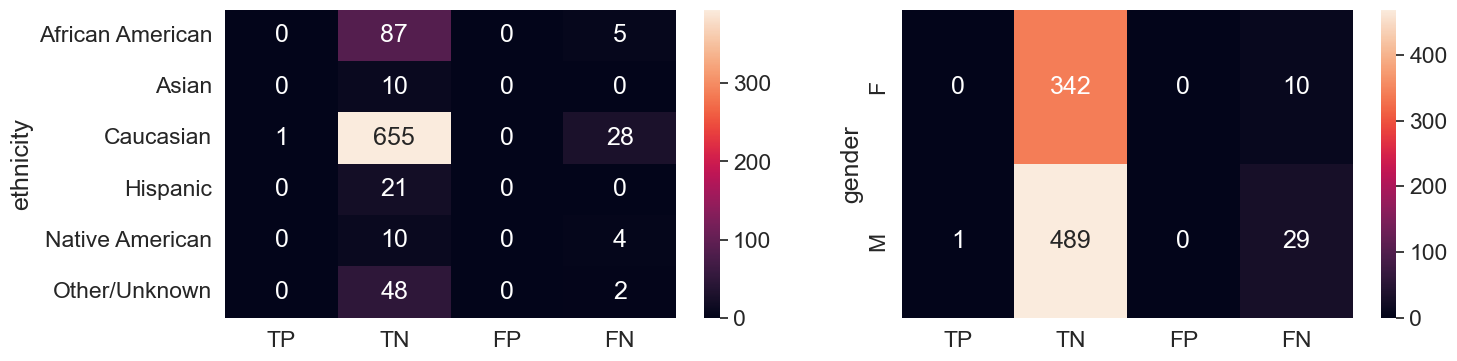

In [14]:
result_df = train_and_evaluate(df=df, features=FEATURES, target=TARGET, groups=GROUPS, use_ethnicity=True)
plot_result_df(result_df)

The model simply says __"no cirrhosis"__ to almost everybody! Especially for the African American
and Asian groups, the model never says "cirrhosis".

What did we do wrong? We will see in the next section how we can improve this.

Before continuing, based on the problems you selected earlier, what should be the evaluation metrics
for those problems?

1. Sepsis prediction in the ICU
2. Early warning system (EWS)
3. Data extraction from clinician notes for flowsheets
4. Bed management

## Part IV: Removing the bias

Previously, we utilized the ethnicity as one of the features. To test if the model is towards a
specific ethnic group, we can intentionally set the "ethnicity" of everyone to, say, "African
American".

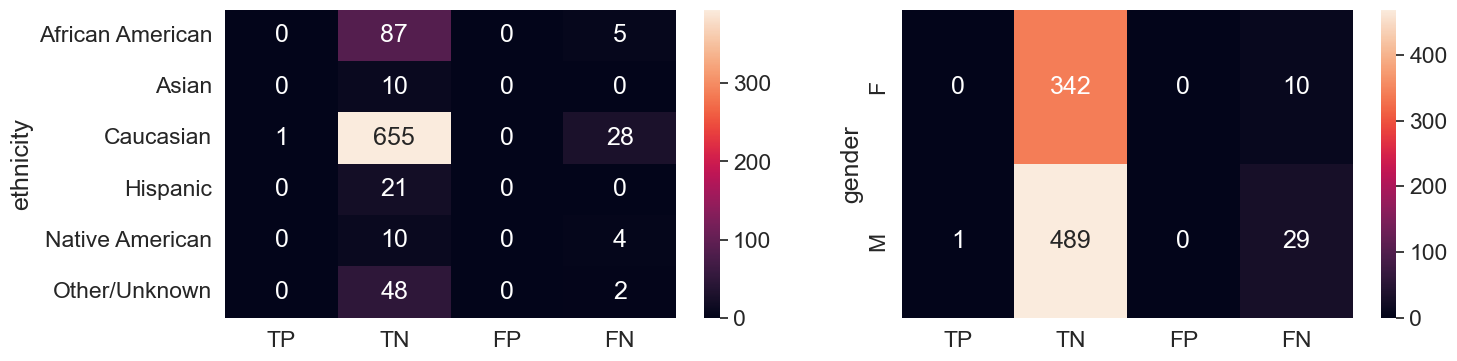

In [15]:
result_df = train_and_evaluate(df=df, features=FEATURES, target=TARGET, groups=GROUPS,
                               use_ethnicity=True, everyone_as_african_american=True)
plot_result_df(result_df)

Interestingly, when masking out the ethnic group by telling the model every subject is African
American, the model never predicts "cirrhosis" to Hispanic and unknown groups. This implies that by
using ethnicity as one of the features, the model is capturing that information as a part of its
decision engine.

We can fix this problem by excluding the "ethnicity" feature from the modeling.

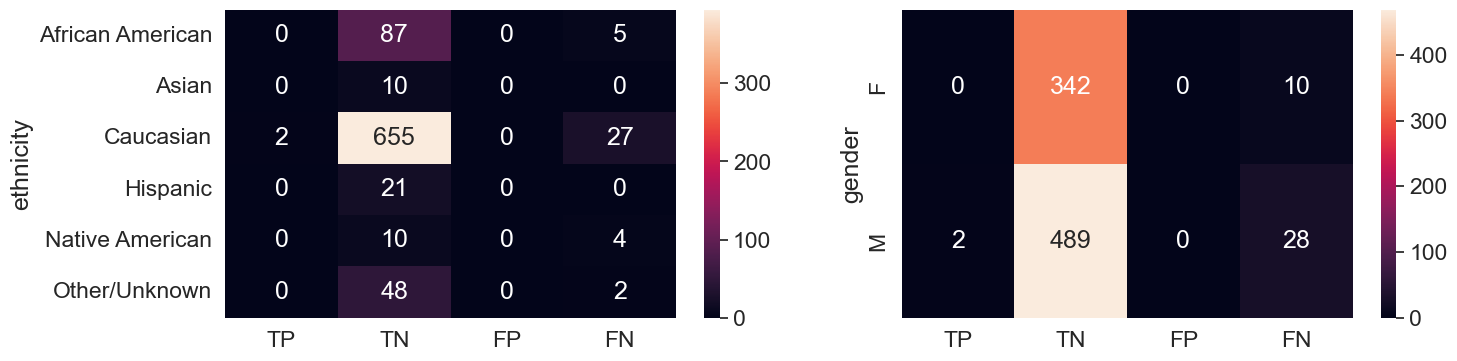

In [16]:
result_df = train_and_evaluate(df=df, features=FEATURES, target=TARGET, groups=GROUPS, use_ethnicity=False)
plot_result_df(result_df)

The results are slightly better although not promising. Another data bias in this dataset not yet
handled properly is the *imbalanced dataset*.

Imbalanced datasets pose a significant challenge in medical AI because the model may learn to favor
the majority class, leading to poor detection of rare but critical conditions. For example, if only
a small fraction of patients have cirrhosis, a model might simply predict "no cirrhosis" for
everyone and still achieve high accuracy, but fail to identify actual cases.

To address this, we can:
- Use evaluation metrics like precision, recall, and F1-score instead of accuracy.
- Apply resampling techniques such as oversampling the minority class or undersampling the majority
  class.
- Employ algorithms or loss functions designed to handle imbalance.
- Collect more data for underrepresented groups if possible.

These strategies help ensure the model learns to recognize both common and rare outcomes, improving
fairness and clinical utility!

At the end of this material, let's take a step further and discuss with the team of this issue.

- Can you think of any example that bias would help training a more accurate model? And why would
  the bias help?
- Stick to that example. How do you know it is a fair bias? Or alternatively, how do you know if it
  is unfair?
- How can we prevent bias into machine learning lifecycle?
- How do we know if ChatGPT is safe from bias? What questions should we ask in order to know the
  answer?